# We will load and test our final models

In [85]:
import numpy as np
import pandas as pd
from pandas import DatetimeIndex as dt
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
import scipy
from scipy.stats import norm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
import pickle

## We need our custom transformers to load our models

In [54]:
# Time Transformer
class Time_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):  # got rid of format thing
        pass
        
    def fit(self, X, y = None):
        return self  # we dont need to fit anything
    
    def transform(self, X):
        # ensuring X is a DataFrame and copying it
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        X_copy = X.copy()
        
        # performing time encoding
        # Time Encoding 
        # Integer Encoding for Time of the Day
        # 1. Morning (10:00 - 11:59), 2. Afternoon (12:00 - 16:59)
        # 3. Evening (17:00 - 18:59), 4. Night (19:00 - 20:59)
        # hour = pd.to_datetime(X_copy['Time']).dt.hour
        hour = pd.to_datetime(X['Time'], format='mixed').dt.strftime('%H').astype('float')
        hour_cat = pd.cut(hour, bins=[0, 12, 17, 19, 24], labels=[1, 2, 3, 4], right=False)
        
        # returning copy with encoded time
        X_copy['Time'] = hour_cat.astype(int)  # make it an integer
        return X_copy

# Date Transformer
class Date_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_copy = X.copy()
        X_copy['Date'] = pd.to_datetime(X_copy['Date']).dt.dayofweek
        return X_copy
    
def compute_confidence_interval(scores):
    """
    Computing the 95% confidence interval 
    """
    mean_score = np.mean(scores)
    sem = stats.sem(scores)  # Standard error of the mean
    confidence_interval = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=sem)
    return confidence_interval


## Loading trained models

In [55]:
with open('final_model1.pkl', 'rb') as file:
    loadedmodel_1 = pickle.load(file)
    
with open('final_model2.pkl', 'rb') as file:
    loadedmodel_2 = pickle.load(file)
    
with open('final_model3.pkl', 'rb') as file:
    loadedmodel_3 = pickle.load(file)
    

## Reading data and setting up data for testing

In [56]:
data = pd.read_csv('supermarket_sales.csv')

data_train, data_test = train_test_split(data, test_size=0.2, random_state=0)

# drop value to be predicted
data_test1 = data_test.drop('gross income', axis =1)

test_target = data_test['gross income']

# Predictions for Gross Income
## Grid Search CV used w/ Lasso

Best found hyperparameters for Grid Search: {'alpha': 0.15}
 Highest R^2 score for Grid Search: 0.8870963838646044
95% CI for R^2 of Grid Search): (0.8934294652454788, 0.8934345695036503)


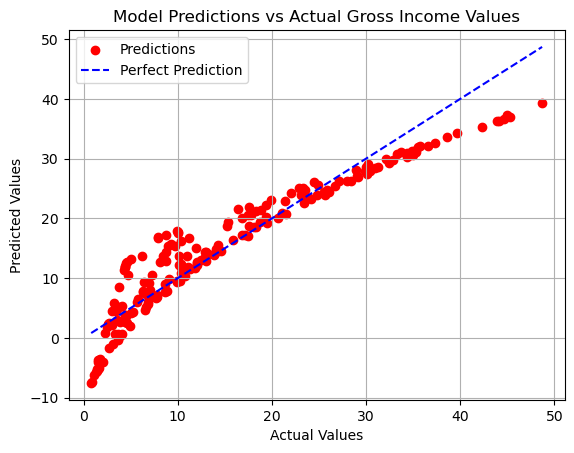

In [57]:
prediction = loadedmodel_1.predict(data_test1)


#printing scores


# Printing scores
print(f"Best found hyperparameters for Grid Search: {loadedmodel_1['Lasso_Grid'].best_params_}")
print(f" Highest R^2 score for Grid Search: {loadedmodel_1['Lasso_Grid'].best_score_}")


# 95% CONFIDENCE INTERVAL
r2_score_grid = r2_score(test_target, prediction)

scores_grid = [r2_score(test_target, prediction + np.random.normal(0, 0.01, len(test_target))) for _ in range(1000)]


ci_grid = compute_confidence_interval(scores_grid)

print(f"95% CI for R^2 of Grid Search): {ci_grid}")

# make the plot
plt.scatter(test_target, prediction, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Model Predictions vs Actual Gross Income Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()





# Predictions for Unit Price
## Randomized Search CV used w/ Lasso

In [58]:
# making data sets 


data_test2 = data_test.drop('Unit price', axis =1)


test_target2 = data_test['Unit price']

In [79]:
prediction1 = loadedmodel_2.predict(data_test2)



# 95% confidence interval
cv_scores2 = cross_validate(loadedmodel_2, data_train2, train_target2, cv=5, scoring=('r2', 'neg_mean_squared_error'))


C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.191e+03, tolerance: 3.617e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.833e+03, tolerance: 3.561e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.407e+03, toleranc

CV R^2 score mean: 0.7773503295959624
CV NMSE scores: [-130.76495299 -169.57112959 -146.74632341 -159.18451193 -160.97776154]
95% Confidence interval for R^2 mean score: (0.7540297386696312, 0.8006709205222936)


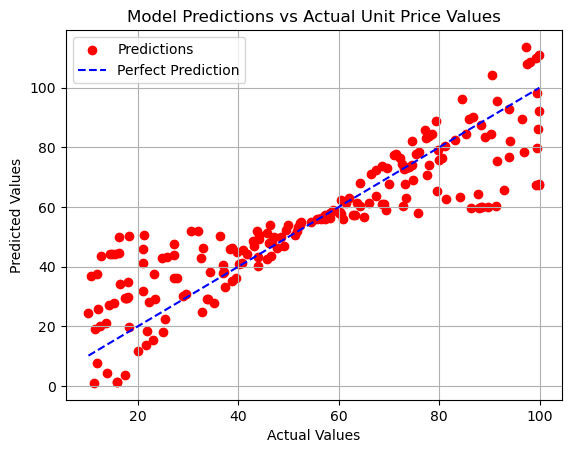

Best Alpha: 0.3449234362955276


In [84]:

# finding mean
r2_scores2 = cv_scores2['test_r2']
up_mean_r2 = np.mean(r2_scores2)

print (f"CV R^2 score mean: {up_mean_r2}")
print (f"CV NMSE scores: {cv_scores2['test_neg_mean_squared_error']}")

std_r2 = np.std(r2_scores2)

# we used 5 folds
n_folds = 5

# finding standard error of mean
sem_r2 = std_r2 / np.sqrt(n_folds)

# calculating 95% interval
up_confidence_interval_95 = scipy.stats.t.interval(0.95, n_folds - 1, loc=up_mean_r2, scale=sem_r2)
print(f"95% Confidence interval for R^2 mean score: {up_confidence_interval_95}")

# make the plot
plt.scatter(test_target2, prediction1, color='red', label='Predictions')

# perfect prediction
plt.plot([min(test_target2), max(test_target2)], [min(test_target2), max(test_target2)],
         color='blue', linestyle='--', label='Perfect Prediction')

plt.title('Model Predictions vs Actual Unit Price Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Best Alpha: {loadedmodel_2[3].best_estimator_.get_params()['alpha']}")


### Looks like our model has an average  R^2 score of 77.03% with a 95% confidence interval of (85.64%, 91.12%)

# Predicting Day of Purchase
## Logistic Regression

In [65]:
data_test3 = data_test.drop('Date', axis = 1)
# to put date in correct format for comparison
encode = Date_Encoder()
target_test3 = encode.transform(data_test['Date'])




prediction2 = loadedmodel_3.predict(data_test3)
print(prediction2)
print(target_test3)

[2 2 6 3 0 6 0 1 6 1 0 2 1 3 0 1 2 6 1 2 5 3 5 5 6 1 0 2 1 1 0 5 5 4 6 6 3
 1 4 5 4 6 2 1 5 6 2 1 1 6 2 1 5 1 2 0 6 5 5 1 6 5 1 3 6 2 5 5 1 2 3 0 6 4
 2 4 2 6 3 5 1 5 2 1 5 1 2 1 1 1 2 4 1 6 5 1 5 2 3 3 3 6 2 1 3 4 2 6 6 5 3
 5 1 3 4 4 6 5 6 3 4 0 5 3 1 4 6 4 2 4 5 6 0 2 4 4 1 0 5 2 5 6 3 5 5 3 0 1
 4 1 1 5 4 1 4 5 5 2 0 6 2 1 6 0 0 2 2 6 3 0 1 4 0 1 1 1 2 1 0 6 2 1 2 2 4
 1 3 3 1 2 1 2 5 3 6 2 4 6 2 5]
     Date
993     4
859     2
298     4
553     3
672     5
..    ...
679     4
722     0
215     4
653     2
150     5

[200 rows x 1 columns]


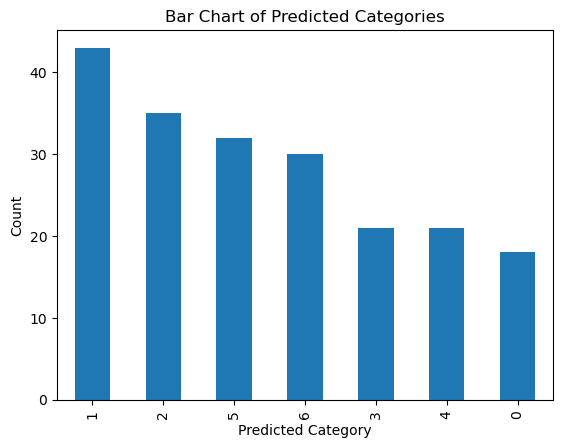

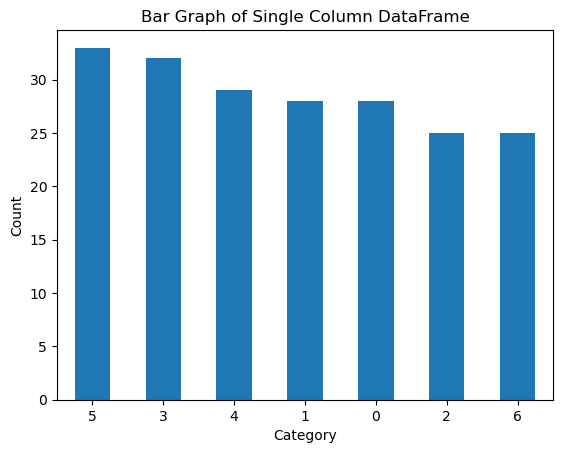

In [78]:
prediction2_series = pd.Series(prediction2)

# Plotting the distribution of prediction2 categories
prediction2_series.value_counts().plot(kind='bar')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.title('Bar Chart of Predicted Categories')
plt.show()

target_test3['Date'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Bar Graph of Single Column DataFrame')
plt.xticks(rotation=0)  # Rotate category labels for better readability if necessary
plt.show()

In [86]:
target_test3_array = target_test3.values.ravel()  # Adjust this line if necessary

# Predicting on the testing data


# Calculating the accuracy score
accuracy = accuracy_score(target_test3_array, prediction2)

print(f"Accuracy Score: {accuracy}")


# for 95% confidence interval
z_score = norm.ppf(0.975)  
margin_of_error = z_score * np.sqrt((accuracy * (1 - accuracy)) / len(target_test3_array))

# finding lower and upper bounds
ci_lower = accuracy - margin_of_error

ci_upper = accuracy + margin_of_error

print(f"95% Confidence Interval for the Accuracy Score: ({ci_lower}, {ci_upper})")

Accuracy Score: 0.16
95% Confidence Interval for the Accuracy Score: (0.10919192655191055, 0.21080807344808944)


## This is an embarrasingly low score, this model is not adequate.